**Import necessary packages**

In [2]:
# Importing libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pybedtools import BedTool
import matplotlib.gridspec as gridspec
%cd /ceph/hpc/home/novljanj/main/magisterij/results/Trying_CNNs

/ceph/hpc/home/novljanj/main/magisterij/results/Trying_CNNs


**Drawing the heatmap visualisation of LIN28A relocalisation in context of PABPC positioning**

In [6]:
# Import the combined clip data
DOX_C1_clip_data = pd.read_csv(os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), 'data', 'Merged_crosslinks', 'DOX_C1_Crick_merged.bed'), sep="\t", header=None, names=["chromosome", "start", "end","name", "score", "strand"])
DOX_C1_GFP_LIN28A_clip_data = pd.read_csv(os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), 'data', 'Merged_crosslinks', 'PABPC1_ESC_DKO_doxGFPLin28A_grouped_cdna_mm39.bed'), sep="\t", header=None, names=["chromosome", "start", "end","name", "score", "strand"])
DOX_C4_clip_data = pd.read_csv(os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), 'data', 'Merged_crosslinks', 'DOX_C4_Proteintech_merged.bed'), sep="\t", header=None, names=["chromosome", "start", "end","name", "score", "strand"])
KO_C1_clip_data = pd.read_csv(os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), 'data', 'Merged_crosslinks', 'KO_C1_Crick_merged.bed'), sep="\t", header=None, names=["chromosome", "start", "end","name", "score", "strand"])
KO_C4_clip_data = pd.read_csv(os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), 'data', 'Merged_crosslinks', 'KO_C4_Proteintech_merged.bed'), sep="\t", header=None, names=["chromosome", "start", "end","name", "score", "strand"])
LIN28A_LIF_clip_data = pd.read_csv(os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), 'data', 'Merged_crosslinks', 'LIN28A-WT_ESC_LIF-CHIR_merged.bed'), sep="\t", header=None, names=["chromosome", "start", "end","name", "score", "strand"])
LIN28A_iLIF_clip_data = pd.read_csv(os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), 'data', 'Merged_crosslinks', 'LIN28A-WT_ESCiLIF_merged.bed'), sep="\t", header=None, names=["chromosome", "start", "end","name", "score", "strand"])

# Import the transcripts
dataset_subset = pd.read_table(r'dataset_subset_95.bed', header=None, names= ['chromosome', 'start', 'end', 'classification', 'log2fold', 'strand', 'gene_name', 'sequence'])

In [7]:
DOX_C1_clip_data

chromosome    start      end name  score strand
0               chr1  3053019  3053020    .      1      -
1               chr1  3053998  3053999    .      1      -
2               chr1  3062699  3062700    .      1      +
3               chr1  3063845  3063846    .      1      +
4               chr1  3063884  3063885    .      1      -
...              ...      ...      ...  ...    ...    ...
13303126  MU069435.1    31085    31086    .      2      +
13303127  MU069435.1    31087    31088    .      1      +
13303128  MU069435.1    31092    31093    .      1      +
13303129  MU069435.1    31100    31101    .      1      -
13303130  MU069435.1    31128    31129    .      1      -

[13303131 rows x 6 columns]

In [8]:
dataset_subset

chromosome      start        end classification  log2fold strand  \
0          chr4  133819715  133819815        CONTROL -0.141645      +   
1          chr7   19314481   19314581           DOWN -1.142632      +   
2         chr11   97921217   97921318        CONTROL  0.110861      +   
3         chr11   95938155   95938256           DOWN -0.701914      +   
4         chr16   93702902   93703003        CONTROL  0.194352      +   
...         ...        ...        ...            ...       ...    ...   
4627      chr13   51303194   51306582           DOWN -2.580964      +   
4628      chr12  100172684  100176073        CONTROL -0.170782      +   
4629       chr8   26254565   26257954        CONTROL  0.095808      -   
4630       chr5  122458934  122462344        CONTROL -0.037340      +   
4631       chr4  148161517  148164942        CONTROL -0.142827      -   

               gene_name                                           sequence  
0     ENSMUSG00000012123  TGAACCAACCAACGCCATCACCAGTTTCCTTCAGGAGGCTTTTGCT...  
1     ENSMUSG00000011267  TGAGCCATATTCTCTGTACAGGTGTCACTAAAGCAAGTGGAAATGG...  
2     ENSMUSG00000017404  TAAAGCTTCCCTCGTGTCTGTACATAGCGGCCTGGCTGTGGCCTCA...  
3     ENSMUSG00000006058  TGACTGAGTGTGGAGGGGTAGACAGCAGCAGGCCAGAAGATGCCCT...  
4     ENSMUSG00000022945  TGAGCCTGCTATGCACCTGCGTGCAGAGGAGGCAAGGCCAAAGCTC...  
...                  ...                                                ...  
4627  ENSMUSG00000021395  TAGATGTCATCACAAACTTTGCCAAATTTGTGGAACTATTAAATGT...  
4628  ENSMUSG00000001175  TGAAGACCTACTTTCAACTACTTTTCCCCCTCTAGAAGAATCAAAT...  
4629  ENSMUSG00000037316  TGAAATAACTTGGAATGCAGGGGAGCCTGTGACTGATTTGGCCAAA...  
4630  ENSMUSG00000038582  TGATGGGCCACACTGGTGACTCCTGCCTTTCCCCTGTCTCCCGACT...  
4631  ENSMUSG00000029007  TGAAGCTGTCCCTGGTCGTCCTGGTCCCCAGCAGGATTCTTGTTCA...  

[4632 rows x 8 columns]

In [11]:
# Create zero-filled dataframe of max_length for each gene
def create_padded_df(df, max_length):
    gene_names = df['gene_name'].unique()
    padded_df = pd.DataFrame(np.nan, index=gene_names, columns=range(max_length))
    return padded_df

def process_data(df, max_length):
    df = df.reindex(columns=["chromosome", "start", "end", "strand", "name", "score"])

    # Create bedtools objects
    bed_data = BedTool.from_dataframe(df[['chromosome', 'start', 'end', 'name', 'score', 'strand']])

    # Find overlaps considering strand specificity
    overlap = utr_bed.intersect(bed_data, wo=True, s=True)

    # Convert back to dataframes
    overlap_df = overlap.to_dataframe(names= ['gene_chromosome', 'gene_start', 'gene_end', 'gene_name', 'log2fold', 'gene_strand', 'clip_chromosome', 'clip_start', 'clip_end', 'clip_name', 'score', 'strand', "idk"])
    
    # Pad sequences
    padded_df = create_padded_df(utr, max_length)

    # Populate padded dataframe with zeros in the range of each gene's length
    for _, row in utr.iterrows():
        gene_name = row['gene_name']
        gene_start = row['start']
        gene_end = row['end']
        gene_length = gene_end - gene_start
        padded_df.loc[gene_name, :gene_length] = 0

    # Populate padded dataframe with scores
    for index, row in overlap_df.iterrows():
        gene_name = row['gene_name']
        gene_start = row['gene_start']
        gene_end = row['gene_end']
        clip_start = row['clip_start']
        clip_end = row['clip_end']
        score = row['score']
        if row['strand'] == "-":
            padded_df.loc[gene_name, gene_end - clip_end] = score
        else:
            padded_df.loc[gene_name, clip_start - gene_start] = score

    # Propagate terminal sequence positions to padded dataframes
    for gene_name, term_seq_pos in dataset_subset[['gene_name', 'term_seq_pos']].values:
        if gene_name in padded_df.index:
            padded_df.loc[gene_name, 'term_seq_pos'] = term_seq_pos

    term_seq_pos_list = [padded_df.loc[gene_name, 'term_seq_pos'] for gene_name in padded_df.index]
    
    return padded_df, term_seq_pos_list, overlap_df

clip_data_dict = {
    'LIN28A_LIF_clip_data': LIN28A_LIF_clip_data, 
    'LIN28A_iLIF_clip_data': LIN28A_iLIF_clip_data,
    'DOX_C4_clip_data': DOX_C4_clip_data,
    'KO_C4_clip_data': KO_C4_clip_data, 
    'DOX_C1_clip_data': DOX_C1_clip_data, 
    'KO_C1_clip_data': KO_C1_clip_data, 
    'DOX_C1_GFP_LIN28A_clip_data': DOX_C1_GFP_LIN28A_clip_data
}

max_length = max(dataset_subset['end'] - dataset_subset['start'])
utr = dataset_subset[dataset_subset["classification"]=="DOWN"][['chromosome', 'start', 'end', 'gene_name', 'log2fold', 'strand']]
utr_bed = BedTool.from_dataframe(utr)

# Add terminal sequence column to dataset_subset
term_seq = 'AATAAA'
dataset_subset['term_seq_pos'] = dataset_subset['sequence'].str.rfind(term_seq)
dataset_subset['term_seq_pos'] = dataset_subset['term_seq_pos'].apply(lambda pos: np.nan if pos == -1 else pos)

# Store processed data in a dictionary
processed_data_dict = {}
for name, data in clip_data_dict.items():
    processed_data_dict[name] = process_data(data, max_length)

***** WARNING: File /tmp/pybedtools.09rj75mb.tmp has inconsistent naming convention for record:
GL456210.1	18380	18381	.	1	-

***** WARNING: File /tmp/pybedtools.09rj75mb.tmp has inconsistent naming convention for record:
GL456210.1	18380	18381	.	1	-

***** WARNING: File /tmp/pybedtools.h8nvfri7.tmp has inconsistent naming convention for record:
GL456210.1	3468	3469	.	1	+

***** WARNING: File /tmp/pybedtools.h8nvfri7.tmp has inconsistent naming convention for record:
GL456210.1	3468	3469	.	1	+

***** WARNING: File /tmp/pybedtools.frnd0wss.tmp has inconsistent naming convention for record:
GL456210.1	1353	1354	.	1	+

***** WARNING: File /tmp/pybedtools.frnd0wss.tmp has inconsistent naming convention for record:
GL456210.1	1353	1354	.	1	+

***** WARNING: File /tmp/pybedtools.mm8g24gr.tmp has inconsistent naming convention for record:
GL456210.1	2465	2466	.	6	-

***** WARNING: File /tmp/pybedtools.mm8g24gr.tmp has inconsistent naming convention for record:
GL456210.1	2465	2466	.	6	-

****

In [12]:
processed_data_dict

{'LIN28A_LIF_clip_data': (                      0    1    2    3    4    5    6    7    8    9  ...  \
  ENSMUSG00000011267  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
  ENSMUSG00000006058  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
  ENSMUSG00000071528  5.0  2.0  3.0  3.0  3.0  1.0  0.0  0.0  0.0  0.0  ...   
  ENSMUSG00000027752  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
  ENSMUSG00000040269  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  ...   
  ...                 ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
  ENSMUSG00000039826  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
  ENSMUSG00000092035  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
  ENSMUSG00000039542  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
  ENSMUSG00000019942  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
  ENSMUSG00000021395  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
  
                      341

In [14]:
#  Smooth the data with simple moving average

window_size = 10
smoothed_data_dict = {}

for key, data in processed_data_dict.items():
    df = data[0]  # accessing the DataFrame
    last_col = df.iloc[:, -1]  # saving the last column
    df_without_last = df.iloc[:, :-1]  # all but the last column

    #df_without_last.replace(np.nan, 0, inplace=True)
    smoothed_df = df_without_last.rolling(window=window_size, min_periods=10, axis=1).mean()
    smoothed_df.iloc[:, :9] = 0
               
    # Remove NaNs and create list of scores for each row
    score_lists = smoothed_df.apply(lambda row: list(row.dropna()), axis=1)

    # Normalise each score by the sum and min max
    # normalized_lists = score_lists.apply(lambda x: [i / sum(x) if sum(x) != 0 else i for i in x])
    normalized_lists = score_lists.apply(lambda x: [(i - 0) / (max(x) - 0) if sum(x) != 0 else i for i in x])

    # Create a dataframe with only nan values with number of columns matching the length of the longest list
    max_length = len(df_without_last.columns)
    nan_df = pd.DataFrame(np.nan, index=df.index, columns=range(max_length))

    # Now fill the dataframe with the values from the lists
    for idx, row in nan_df.iterrows():
        nan_df.loc[idx, :len(normalized_lists.loc[idx])-1] = normalized_lists.loc[idx]
    
    #smoothed_df.replace(0, np.nan, inplace=True)
    summed_clip = df_without_last.sum(axis=1)

    lengths= df_without_last.iloc[:, ::-1].notna().idxmax(axis=1)    

    summed_and_norm_clip = summed_clip / (lengths/1000)

    nan_df[last_col.name] = last_col  # adding the last column back
    smoothed_data_dict[key] = (nan_df, data[1], summed_and_norm_clip)  # replace first element and keep the second


In [15]:
smoothed_data_dict

{'LIN28A_LIF_clip_data': (                      0    1    2    3    4    5    6    7    8         9  \
  ENSMUSG00000011267  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000   
  ENSMUSG00000006058  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.333333   
  ENSMUSG00000071528  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.000000   
  ENSMUSG00000027752  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.100000   
  ENSMUSG00000040269  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.333333   
  ...                 ...  ...  ...  ...  ...  ...  ...  ...  ...       ...   
  ENSMUSG00000039826  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000   
  ENSMUSG00000092035  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000   
  ENSMUSG00000039542  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000   
  ENSMUSG00000019942  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000   
  ENSMUSG00000021395  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000   
  
                      ...

In [ ]:
# Create data for the expresion normalised clip data per gene

quantseq_counts = pd.read_csv(os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), 'data', '3’ UTRs of genes in bed file format', 'mean_gene-level_TPMs_suplementary.csv'))
quantseq_counts_down = pd.merge(utr, quantseq_counts, left_on='gene_name', right_on='geneID', how='left')
quantseq_counts_subset = quantseq_counts_down[['geneID', 'S200WT_FCL', 'S200WT_2iL', 'S200WT_FCL', 'KO_FCL', 'S200WT_FCL', 'KO_FCL']]
quantseq_counts_subset = quantseq_counts_subset.set_index('geneID',)
quantseq_counts_subset.index.name = None

normalised_clip_data_dict = {
    'LIN28A_LIF_clip_data_down_normalised': smoothed_data_dict['LIN28A_LIF_clip_data'][2] / (LIN28A_LIF_clip_data['score'].sum() / 1e6),
    'LIN28A_iLIF_clip_data_down_normalised': smoothed_data_dict['LIN28A_iLIF_clip_data'][2] / (LIN28A_iLIF_clip_data['score'].sum() / 1e6),
    'DOX_C4_clip_data_down_normalised': smoothed_data_dict['DOX_C4_clip_data'][2] / (DOX_C1_clip_data['score'].sum() / 1e6),
    'KO_C4_clip_data_down_normalised': smoothed_data_dict['KO_C4_clip_data'][2] / (KO_C1_clip_data['score'].sum() / 1e6),
    'DOX_C1_clip_data_down_normalised': smoothed_data_dict['DOX_C1_clip_data'][2] / (DOX_C1_clip_data['score'].sum() / 1e6),
    'KO_C1_clip_data_down_normalised': smoothed_data_dict['KO_C1_clip_data'][2] / (KO_C1_clip_data['score'].sum() / 1e6)
}

normalised_clip_data_df = pd.DataFrame.from_dict(normalised_clip_data_dict)

# Create a dictionary to hold the resulting dataframes
expression_data = {}

# Iterate over the items in normalised_clip_data_dict
for i, (key, df) in enumerate(normalised_clip_data_dict.items()):
    # Extract corresponding column from quantseq_counts_subset and rename it
    quantseq_col = quantseq_counts_subset.iloc[:, i].rename(quantseq_counts_subset.columns[i])
    normalised_clip_column = df.rename(key)
    # Create a new dataframe by concatenating the current dataframe with the corresponding column from quantseq_counts_subset
    new_df = pd.concat([normalised_clip_column, quantseq_col], axis=1)

    # Add the new dataframe to the dictionary
    expression_data[i] = new_df
    
expression_data

{0:                     LIN28A_LIF_clip_data_down_normalised  S200WT_FCL
 ENSMUSG00000011267                              0.000000   26.041584
 ENSMUSG00000006058                             11.908779   82.041514
 ENSMUSG00000071528                             75.468970  375.074216
 ENSMUSG00000027752                             56.052196  117.172725
 ENSMUSG00000040269                             14.013049    1.053519
 ...                                                  ...         ...
 ENSMUSG00000039826                             12.421079    7.321705
 ENSMUSG00000092035                             20.755405    4.762603
 ENSMUSG00000039542                             12.572937    5.577195
 ENSMUSG00000019942                              4.445471   27.268542
 ENSMUSG00000021395                             18.957736    0.771209
 
 [1123 rows x 2 columns],
 1:                     LIN28A_iLIF_clip_data_down_normalised  S200WT_2iL
 ENSMUSG00000011267                               1.590

In [ ]:
draw_sequence_index_start = 600
draw_sequence_index_end = 800
max_length = 1200

gs = gridspec.GridSpec(6, 40)
# Create an extra subplot for each row
fig, axes = plt.subplots(len(smoothed_data_dict), 4, figsize=(20, 15), dpi=600, sharey=True)
axes = axes.ravel()  # flatten axes
cbar_ax = fig.add_axes([1, 0.04, .03, 0.936])  # position of the colorbar

custom_titles = ["LIN28A-LIF CLIP-seq peaks", "LIN28A-iLIF CLIP-seq peaks", "PABPC4-DOX CLIP-seq peaks", "PABPC4-KO CLIP-seq peaks", "PABPC1-DOX CLIP-seq peaks", "PABPC1-KO CLIP-seq peaks"]

for i, (name, data) in enumerate(smoothed_data_dict.items()):
    if i >= 6:
        break

    print(name)
    padded_df, term_seq_pos_list, summed_and_norm_clip = data
    
    padded_df = padded_df.iloc[draw_sequence_index_start:draw_sequence_index_end, :max_length]
    
    term_seq_pos_list = term_seq_pos_list[draw_sequence_index_start:draw_sequence_index_end]
    padded_df_copy = padded_df.iloc[:, :-1].copy()

    indices = (padded_df_copy.iloc[:, ::-1].notna().idxmax(axis=1)-200).tolist()
    # Smooth the indices
    indices_series = pd.Series(indices)

    # Now you can apply the rolling function
    indices_rolling_avg = indices_series.rolling(window=10, min_periods=1, center=True).mean()

    # Convert the smoothed series back to a list if needed
    indices_smoothed = indices_rolling_avg.tolist()

    # Invert the order of rows
    padded_df_copy = padded_df_copy[::-1]
    term_seq_pos_list = term_seq_pos_list[::-1]
    indices_smoothed = indices_smoothed[::-1]

    padded_df_copy.index = range(1, len(padded_df_copy) + 1)  # change index to sequence numbers starting from 1
    normalised_with_expression = pd.DataFrame()
    # Draw heatmaps from Code 1 on the left of each heatmap from Code 2
    normalised_with_expression["score"] = expression_data[i].iloc[:, 0] / expression_data[i].iloc[:, 1]

    # Third heatmap from Code 1
    ax1 = plt.subplot(gs[i, 0:1])  # we use the second "column" for the second smaller heatmap
    sns.heatmap(normalised_with_expression.iloc[:, [0]].iloc[draw_sequence_index_start:draw_sequence_index_end], cmap="YlOrRd", ax=ax1, norm=colors.LogNorm(vmin=1e-2, vmax=1e2))
    ax1.set_title('Sum of Library Size, Length \n and Expresion Normalised \n Transcript CLIP Counts', fontsize=6)
    ax1.set_yticklabels([])  # remove the y-tick labels
    ax1.set_xticklabels([])
    ax1.set_xticks([])
    ax1.spines['bottom'].set_visible(False)

    # First heatmap from Code 1
    ax2 = plt.subplot(gs[i, 5:6])  # we use the first "column" for the first smaller heatmap
    sns.heatmap(expression_data[i].iloc[:, [0]].iloc[draw_sequence_index_start:draw_sequence_index_end], cmap="YlGnBu", ax=ax2, norm=colors.LogNorm(vmin=1e-1, vmax=1e4))
    ax2.set_title('Sum of Length and Library Size Normalised \n Transcript CLIP Counts', fontsize=6)
    ax2.set_yticklabels([])  # remove the y-tick labels
    ax2.set_xticklabels([])
    ax2.set_xticks([])
    ax2.spines['bottom'].set_visible(False)

    # Second heatmap from Code 1
    ax3 = plt.subplot(gs[i, 10:11])  # we use the second "column" for the second smaller heatmap
    sns.heatmap(expression_data[i].iloc[:, [1]].iloc[draw_sequence_index_start:draw_sequence_index_end], cmap="YlOrRd", ax=ax3, norm=colors.LogNorm(vmin=1e0, vmax=1e3))
    ax3.set_title('Mean of Normalised \n Transcript QuantSeq Counts', fontsize=6)
    ax3.set_yticklabels([])  # remove the y-tick labels
    ax3.set_xticklabels([])
    ax3.set_xticks([])
    ax3.spines['bottom'].set_visible(False)


    # Draw heatmaps on the i-th subplot
    ax = plt.subplot(gs[i, 16:])  # we use the remaining "columns" for the large heatmap
    im = ax.imshow(padded_df_copy, cmap='Blues', vmax=0.3, aspect='auto')

    # Draw terminal sequence positions
    scatter_plot = ax.scatter(term_seq_pos_list, range(1, len(term_seq_pos_list) + 1), c='green', s=1, label='PolyA Signal')
    line_plot = ax.plot(indices_smoothed, range(1, len(indices_smoothed) + 1), 'k--', label='-200bp of the Transcript End')

    # Set x-axis and y-axis ticks and labels
    ax.set_xticks(np.arange(0, max_length + 1, step=100))
    ax.set_yticks(np.arange(0,len(padded_df_copy)+1,  step=50))
    ax.set_yticklabels(np.arange(0,len(padded_df_copy)+1,  step=50))
    ax.set_ylim(0, len(padded_df_copy)) 

    # Set the x labels to be empty for all but the last plot
    if i < 5:  # replace 3 with the number of plots - 1
        ax.set_xticks([])
        ax.set_xticklabels([])
        ax.spines['bottom'].set_visible(False)
    else:
        ax.set_xticklabels(np.arange(0, max_length + 1, step=100))
        ax.set_xlabel('3\'UTR sequence', fontsize=15)
        
    ax.set_ylabel('Transcripts', fontsize=13)  # Add y label

    ax.set_title(custom_titles[i], fontsize=13)  # Add title
    
    # Remove top and right borders
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    if i == 0:  # if this is the first graph
        legend1 = ax.legend(handles=[scatter_plot, line_plot[0]], loc='upper right', frameon=False)
        # Change the size of legend markers
        legend1.legendHandles[0]._sizes = [25]  # set the marker size as per your preference

# Common colorbar for all subplots
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.outline.set_visible(False)  # remove colorbar border

plt.subplots_adjust(wspace=0.2, hspace=0.4)

plt.savefig('heatmap_with_quantseq_all_600dpi.pdf', bbox_inches='tight')
plt.show()



LIN28A_LIF_clip_data


Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.


LIN28A_iLIF_clip_data


Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.


DOX_C4_clip_data


Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.


KO_C4_clip_data


Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.


DOX_C1_clip_data


Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.


KO_C1_clip_data


Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.


[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


**Metaprofile of crosslinking counts across multiple transcript regions - 5' UTR, CDS, and 3' UTR - in both UP+control and DOWN states**

In [16]:
# Reads a CSV file containing transcript names into a pandas DataFrame
transcipt_names = pd.read_csv(os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), 'data', '3’ UTRs of genes in bed file format', 'ThreePrimeUtrsOfMostExpressedTxInS200WT2iL.bed'), sep='\t', header=None)

# Reads a CSV file into a pandas DataFrame. This DataFrame is named 'quantseq'
quantseq = pd.read_csv(os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), 'data', '3’ UTRs of genes in bed file format', 'QuantseqGroups.bed'), sep='\t', header=None)

# Merges the two dataframes, 'transcipt_names' and 'quantseq', on common elements present in column 3 of the left DataFrame and column 6 of the right DataFrame.
merged = pd.merge(transcipt_names, quantseq, left_on=[3], right_on=[6], how='right')

# Selects certain columns from the merged dataframe
quantseq_with_transcript_names = merged[['0_y', '1_y', '2_y', '3_y', '4_y', '5_y', '6_y', 7]]

# Writes the 'quantseq_with_transcript_names' DataFrame to a TSV (tab-separated values) file. 
quantseq_with_transcript_names.to_csv(os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), 'data', '3’ UTRs of genes in bed file format', 'QuantseqGroupsTranscriptNames.bed'), sep='\t', header=None, index=False)

In [17]:
quantseq_with_transcript_names

0_y        1_y        2_y   3_y       4_y 5_y                 6_y  \
0     chr10   24648303   24649802  DOWN -6.899042   -  ENSMUSG00000019989   
1      chr4   99546268   99546859  DOWN -5.904965   +  ENSMUSG00000067261   
2      chrX   85239198   85239553  DOWN -5.527307   +  ENSMUSG00000025056   
3     chr15   85760430   85760774  DOWN -4.238394   +  ENSMUSG00000022385   
4     chr13  114588825  114590341  DOWN -4.188287   -  ENSMUSG00000021765   
...     ...        ...        ...   ...       ...  ..                 ...   
4871   chr2  152454543  152454649    UP  6.869512   +  ENSMUSG00000044863   
4872  chr15   85419637   85421592    UP  7.345146   -  ENSMUSG00000022382   
4873   chr8   95739612   95740845    UP  8.463418   +  ENSMUSG00000031785   
4874  chr18   67500590   67500855    UP  8.887039   +  ENSMUSG00000024526   
4875  chr11  114682042  114682276    UP  9.924614   -  ENSMUSG00000000202   

                       7  
0     ENSMUST00000020169  
1     ENSMUST00000087285  
2     ENSMUST00000026036  
3     ENSMUST00000231074  
4     ENSMUST00000223640  
...                  ...  
4871  ENSMUST00000058086  
4872  ENSMUST00000109424  
4873  ENSMUST00000179619  
4874  ENSMUST00000025404  
4875  ENSMUST00000000206  

[4876 rows x 8 columns]

In [18]:
# Uses a shell command 'awk' to get column 8 from the TSV file. Then for each value, it executes 'grep' command to find this value in the gencode file. The found lines are redirected to 'test.bed' file.
!awk '{print $8}' "../../data/3’ UTRs of genes in bed file format/QuantseqGroupsTranscriptNames.tsv" | xargs -I{} grep -wF {} ../../data/gencode.vM28.primary_assembly.annotation.gencode_utr_fix.gtf > whole_transcript_info.bed

# Reads the 'test.bed' file into a DataFrame 'transcripts'. Also assigns column names.
transcripts = pd.read_csv('whole_transcript_info.bed', sep='\t', header=None, names=["seqname", "source", "feature", "start", "end", "score", "strand", "frame", "attribute"])

In [19]:
# Reads the 'test.bed' file into a DataFrame 'transcripts'. Also assigns column names.
transcripts = pd.read_csv('whole_transcript_info.bed', sep='\t', header=None, names=["seqname", "source", "feature", "start", "end", "score", "strand", "frame", "attribute"])

In [20]:
transcripts

seqname  source          feature      start        end score strand  \
0        chr10  HAVANA       transcript   24648304   24712123     .      -   
1        chr10  HAVANA             exon   24711914   24712123     .      -   
2        chr10  HAVANA              CDS   24711914   24711991     .      -   
3        chr10  HAVANA      start_codon   24711989   24711991     .      -   
4        chr10  HAVANA             exon   24707629   24707704     .      -   
...        ...     ...              ...        ...        ...   ...    ...   
125597   chr11  HAVANA             exon  114682043  114683348     .      -   
125598   chr11  HAVANA              CDS  114682277  114683348     .      -   
125599   chr11  HAVANA       stop_codon  114682274  114682276     .      -   
125600   chr11  HAVANA   five_prime_utr  114686675  114686723     .      -   
125601   chr11  HAVANA  three_prime_utr  114682043  114682276     .      -   

       frame                                          attribute  
0          .  gene_id "ENSMUSG00000019989.9"; gene_type "pro...  
1          .  gene_id "ENSMUSG00000019989.9"; gene_type "pro...  
2          0  gene_id "ENSMUSG00000019989.9"; gene_type "pro...  
3          0  gene_id "ENSMUSG00000019989.9"; gene_type "pro...  
4          .  gene_id "ENSMUSG00000019989.9"; gene_type "pro...  
...      ...                                                ...  
125597     .  gene_id "ENSMUSG00000000202.10"; gene_type "pr...  
125598     1  gene_id "ENSMUSG00000000202.10"; gene_type "pr...  
125599     0  gene_id "ENSMUSG00000000202.10"; gene_type "pr...  
125600     .  gene_id "ENSMUSG00000000202.10"; gene_type "pr...  
125601     .  gene_id "ENSMUSG00000000202.10"; gene_type "pr...  

[125602 rows x 9 columns]

In [21]:
# This function 'parse_attributes' is used to parse the 'attribute' string into key-value pairs and returns a dictionary of these pairs.
def parse_attributes(attribute_str):
    pairs = attribute_str.split('; ')  # Split the string into key-value pairs
    pairs = pairs[:-1]  # Remove the trailing semicolon
    pairs = [pair.split(' ') for pair in pairs]  # Split each pair into a key and a value
    pairs = [(key, value.strip('"')) for key, value in pairs]  # Remove the quotes around each value
    return dict(pairs)  # Convert the list of pairs into a dictionary

# Applies 'parse_attributes' function to the 'attribute' column and returns a Series of dictionaries.
attribute_dicts = transcripts['attribute'].apply(parse_attributes)

# Converts the Series of dictionaries into a DataFrame 'attributes_df'.
attributes_df = pd.DataFrame(list(attribute_dicts))

# Drops the 'attribute' column from the original 'transcripts' DataFrame.
transcripts_separate = transcripts.drop('attribute', axis=1)

# Concatenates the original 'transcripts' DataFrame with the 'attributes_df' DataFrame.
transcripts_separate = pd.concat([transcripts_separate, attributes_df], axis=1)

In [22]:
transcripts_separate

seqname  source          feature      start        end score strand  \
0        chr10  HAVANA       transcript   24648304   24712123     .      -   
1        chr10  HAVANA             exon   24711914   24712123     .      -   
2        chr10  HAVANA              CDS   24711914   24711991     .      -   
3        chr10  HAVANA      start_codon   24711989   24711991     .      -   
4        chr10  HAVANA             exon   24707629   24707704     .      -   
...        ...     ...              ...        ...        ...   ...    ...   
125597   chr11  HAVANA             exon  114682043  114683348     .      -   
125598   chr11  HAVANA              CDS  114682277  114683348     .      -   
125599   chr11  HAVANA       stop_codon  114682274  114682276     .      -   
125600   chr11  HAVANA   five_prime_utr  114686675  114686723     .      -   
125601   chr11  HAVANA  three_prime_utr  114682043  114682276     .      -   

       frame                gene_id       gene_type  ...  \
0          .   ENSMUSG00000019989.9  protein_coding  ...   
1          .   ENSMUSG00000019989.9  protein_coding  ...   
2          0   ENSMUSG00000019989.9  protein_coding  ...   
3          0   ENSMUSG00000019989.9  protein_coding  ...   
4          .   ENSMUSG00000019989.9  protein_coding  ...   
...      ...                    ...             ...  ...   
125597     .  ENSMUSG00000000202.10  protein_coding  ...   
125598     1  ENSMUSG00000000202.10  protein_coding  ...   
125599     0  ENSMUSG00000000202.10  protein_coding  ...   
125600     .  ENSMUSG00000000202.10  protein_coding  ...   
125601     .  ENSMUSG00000000202.10  protein_coding  ...   

                 havana_gene         transcript_id transcript_type  \
0       OTTMUSG00000064354.1  ENSMUST00000020169.9  protein_coding   
1       OTTMUSG00000064354.1  ENSMUST00000020169.9  protein_coding   
2       OTTMUSG00000064354.1  ENSMUST00000020169.9  protein_coding   
3       OTTMUSG00000064354.1  ENSMUST00000020169.9  protein_coding   
4       OTTMUSG00000064354.1  ENSMUST00000020169.9  protein_coding   
...                      ...                   ...             ...   
125597  OTTMUSG00000003464.1  ENSMUST00000000206.4  protein_coding   
125598  OTTMUSG00000003464.1  ENSMUST00000000206.4  protein_coding   
125599  OTTMUSG00000003464.1  ENSMUST00000000206.4  protein_coding   
125600  OTTMUSG00000003464.1  ENSMUST00000000206.4  protein_coding   
125601  OTTMUSG00000003464.1  ENSMUST00000000206.4  protein_coding   

       transcript_name transcript_support_level   tag     havana_transcript  \
0            Enpp3-201                        1  CCDS  OTTMUST00000157062.1   
1            Enpp3-201                        1  CCDS  OTTMUST00000157062.1   
2            Enpp3-201                        1  CCDS  OTTMUST00000157062.1   
3            Enpp3-201                        1  CCDS  OTTMUST00000157062.1   
4            Enpp3-201                        1  CCDS  OTTMUST00000157062.1   
...                ...                      ...   ...                   ...   
125597      Btbd17-201                        1  CCDS  OTTMUST00000007348.1   
125598      Btbd17-201                        1  CCDS  OTTMUST00000007348.1   
125599      Btbd17-201                        1  CCDS  OTTMUST00000007348.1   
125600      Btbd17-201                        1  CCDS  OTTMUST00000007348.1   
125601      Btbd17-201                        1  CCDS  OTTMUST00000007348.1   

                  protein_id exon_number               exon_id  
0       ENSMUSP00000020169.8         NaN                   NaN  
1       ENSMUSP00000020169.8           1  ENSMUSE00000099590.8  
2       ENSMUSP00000020169.8           1  ENSMUSE00000099590.8  
3       ENSMUSP00000020169.8           1  ENSMUSE00000099590.8  
4       ENSMUSP00000020169.8           2  ENSMUSE00000099585.4  
...                      ...         ...                   ...  
125597  ENSMUSP00000000206.4           3  ENSMUSE00000258911.5  
125598  ENSMUSP00000000206.4           

In [27]:
# Filters the 'transcripts_separate' DataFrame for rows where 'feature' is 'CDS', 'five_prime_utr' or 'three_prime_utr' and assigns the result to 'CDS_5prime_3_prime_subset'.
CDS_5prime_3_prime_subset = transcripts_separate[(transcripts_separate['feature'] == 'CDS') | (transcripts_separate['feature'] == 'five_prime_utr') | (transcripts_separate['feature'] == 'three_prime_utr')]

# Truncates the transcript id after the '.' and stores it in a new column 'transcript_id_truncated'.
CDS_5prime_3_prime_subset['transcript_id_truncated'] = CDS_5prime_3_prime_subset['transcript_id'].str.split('.').str[0]

# Merges 'CDS_5prime_3_prime_subset' DataFrame and 'quantseq_with_transcript_names' DataFrame on 'transcript_id_truncated' and 7th column respectively.
CDS_5prime_3_prime_subset_merged = pd.merge(CDS_5prime_3_prime_subset, quantseq_with_transcript_names, left_on=['transcript_id_truncated'], right_on=[7])

# Selects certain columns from the merged dataframe
CDS_5prime_3_prime_subset_merged_important_columns = CDS_5prime_3_prime_subset_merged[['seqname', 'start', 'end', '3_y', '4_y', '5_y', '6_y', 7, 'feature']]
['chromosome', 'start', 'end', 'group', 'log2fold', 'strand', 'gene', 'transcript_name', 'feature']

# Writes the 'CDS_5prime_3_prime_subset_merged_important_columns' DataFrame to a TSV (tab-separated values) file. 
CDS_5prime_3_prime_subset_merged_important_columns.to_csv(os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), 'data', '3’ UTRs of genes in bed file format', 'CDS_5prime_3_prime_subset.tsv'), sep='\t', header=None, index=False)

/tmp/ipykernel_2642501/3639691560.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CDS_5prime_3_prime_subset['transcript_id_truncated'] = CDS_5prime_3_prime_subset['transcript_id'].str.split('.').str[0]


In [28]:
CDS_5prime_3_prime_subset_merged_important_columns

seqname      start        end   3_y       4_y 5_y                 6_y  \
0       chr10   24711914   24711991  DOWN -6.899042   -  ENSMUSG00000019989   
1       chr10   24707629   24707704  DOWN -6.899042   -  ENSMUSG00000019989   
2       chr10   24702074   24702196  DOWN -6.899042   -  ENSMUSG00000019989   
3       chr10   24700701   24700826  DOWN -6.899042   -  ENSMUSG00000019989   
4       chr10   24696470   24696530  DOWN -6.899042   -  ENSMUSG00000019989   
...       ...        ...        ...   ...       ...  ..                 ...   
60291   chr11  114686590  114686674    UP  9.924614   -  ENSMUSG00000000202   
60292   chr11  114684676  114684952    UP  9.924614   -  ENSMUSG00000000202   
60293   chr11  114682277  114683348    UP  9.924614   -  ENSMUSG00000000202   
60294   chr11  114686675  114686723    UP  9.924614   -  ENSMUSG00000000202   
60295   chr11  114682043  114682276    UP  9.924614   -  ENSMUSG00000000202   

                        7          feature  
0      ENSMUST00000020169              CDS  
1      ENSMUST00000020169              CDS  
2      ENSMUST00000020169              CDS  
3      ENSMUST00000020169              CDS  
4      ENSMUST00000020169              CDS  
...                   ...              ...  
60291  ENSMUST00000000206              CDS  
60292  ENSMUST00000000206              CDS  
60293  ENSMUST00000000206              CDS  
60294  ENSMUST00000000206   five_prime_utr  
60295  ENSMUST00000000206  three_prime_utr  

[60296 rows x 9 columns]

In [51]:
# Import the combined CLIP data for different protein and condition combinations
clip_data_LIN28_iLIF = pd.read_csv(os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), 'data', 'Merged_crosslinks', 'LIN28A-WT_ESCiLIF_merged.bed'), sep="\t", header=None, names=["chromosome", "start", "end","name", "score", "strand"])
clip_data_LIN28_LIF = pd.read_csv(os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), 'data', 'Merged_crosslinks', 'LIN28A-WT_ESC_LIF-CHIR_merged.bed'), sep="\t", header=None, names=["chromosome", "start", "end","name", "score", "strand"])
clip_data_PABPC4_DOX = pd.read_csv(os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), 'data', 'Merged_crosslinks', 'DOX_C4_Proteintech_merged.bed'), sep="\t", header=None, names=["chromosome", "start", "end","name", "score", "strand"])
clip_data_PABPC4_KO = pd.read_csv(os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), 'data', 'Merged_crosslinks', 'KO_C4_Proteintech_merged.bed'), sep="\t", header=None, names=["chromosome", "start", "end","name", "score", "strand"])
clip_data_PABPC1_DOX = pd.read_csv(os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), 'data', 'Merged_crosslinks', 'DOX_C1_Crick_merged.bed'), sep="\t", header=None, names=["chromosome", "start", "end","name", "score", "strand"])
clip_data_PABPC1_KO = pd.read_csv(os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), 'data', 'Merged_crosslinks', 'KO_C1_Crick_merged.bed'), sep="\t", header=None, names=["chromosome", "start", "end","name", "score", "strand"])

# Import a subset of the gene expression dataset
CDS_5prime_3_prime_subset = pd.read_table(os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), 'data', '3’ UTRs of genes in bed file format', 'CDS_5prime_3_prime_subset.tsv'), header=None, names=['chromosome', 'start', 'end', 'group', 'log2fold', 'strand', 'gene', 'transcript_name', 'feature'])

# Reindex columns to ensure compatibility with bedtools library
CDS_5prime_3_prime_subset = CDS_5prime_3_prime_subset.reindex(columns=['chromosome', 'start', 'end','gene', 'log2fold', 'strand','group', 'transcript_name', 'feature'])

# Load TPM counts for each gene (transcripts per million) from a CSV file
quantseq_counts = pd.read_csv(os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), 'data', '3’ UTRs of genes in bed file format', 'mean_gene-level_TPMs_suplementary.csv'))

# Function to process each gene group
def process_gene(gene_group, clip_data, quantseq_counts, clip_data_name):
    # Group by the second column
    grouped_data = gene_group.groupby(1)
    # Iterate over each group
    for index, (name, group) in enumerate(grouped_data):
        if index == 0:
            df = group
            previous_name = group[2].reset_index(drop=True)[0]
        else:
            # Apply the difference to specified columns within each group
            group[[1,2, 10, 11]] = group[[1,2, 10, 11]] - (name-previous_name)
            df = pd.concat([df, group])
            previous_name = group[2].reset_index(drop=True)[0]

    # Assign concatenated DataFrame to gene_group
    gene_group = df

    # Calculate gene length
    gene_length = gene_group[2].max() - gene_group[1].min()

    # Calculate spikes per kilobase (spkb)
    gene_group["spkb"] = gene_group[13] / (gene_length / 1000)
    # Calculate library size in millions
    library_size_pm = clip_data['score'].sum() / 1e6

    # Normalize score with spikes per kilobase and library size in millions
    gene_group["score_norm"] = gene_group["spkb"] / library_size_pm

    # Mapping to avoid multiple if conditions
    mapping_dict = {
        'clip_data_LIN28_LIF': "S200WT_FCL",
        'clip_data_LIN28_iLIF': "S200WT_2iL",
        'clip_data_PABPC4_DOX': "S200WT_FCL",
        'clip_data_PABPC4_KO': "KO_FCL",
        'clip_data_PABPC1_DOX': "S200WT_FCL",
        'clip_data_PABPC1_KO': "KO_FCL",
    }

    # Get gene id from the gene_group
    gene_id = gene_group[3].iloc[0]

    # Normalize the expression with quantseq_counts
    if clip_data_name in mapping_dict:
        denominator = float(quantseq_counts[quantseq_counts["geneID"] == gene_id][mapping_dict[clip_data_name]])
        gene_group["exp_norm"] = gene_group["score_norm"] / denominator

    # Bin the data into 100 equally spaced intervals
    bins = np.linspace(gene_group[1].min(), gene_group[2].max(), 100)
    # Calculate the histogram
    binned_counts, _ = np.histogram(gene_group[10], bins=bins, weights=gene_group["exp_norm"])
    # Reverse the array if the sixth column contains '-'
    if gene_group[5].iloc[0] == '-':
        binned_counts = binned_counts[::-1]
        
    return pd.Series(binned_counts)

# Function to process each clip data set
def process_clip_dataset(clip_data, genes_bed, quantseq_counts, clip_data_name):
    print(clip_data_name)
    # Convert DataFrame to BedTool object
    clip_bed = BedTool.from_dataframe(clip_data)
    # Find the intersection of two BedTool objects
    intersected = genes_bed.intersect(clip_bed, s=True, wao=True)
    # Read the intersection into a DataFrame
    df_intersected = pd.read_table(intersected.fn, header=None)
    # Replace -1 with NaN
    df_intersected.replace(-1, np.nan, inplace=True)
    # Apply process_gene function on each gene group
    binned_counts = df_intersected.groupby(3).apply(process_gene, clip_data, quantseq_counts, clip_data_name)
    # Calculate the mean of binned_counts
    average_counts = binned_counts.mean()
    # Calculate the standard error of binned_counts
    average_counts_se = binned_counts.sem()
    return average_counts, average_counts_se

# Split the CDS, 5' and 3' prime data into different DataFrames based on gene group
# 'DOWN' group represents downregulated genes
# Those not in 'DOWN' are considered upregulated
# BedTool object is created for each group for easy intersection operation with clip data

# Downregulated genes
CDS_bed_down = BedTool.from_dataframe(CDS_5prime_3_prime_subset[(CDS_5prime_3_prime_subset['feature']=='CDS') & (CDS_5prime_3_prime_subset['group']=='DOWN')].sort_values(['chromosome', 'start']).reset_index(drop=True))
Five_prime_bed_down = BedTool.from_dataframe(CDS_5prime_3_prime_subset[(CDS_5prime_3_prime_subset['feature']=='five_prime_utr') & (CDS_5prime_3_prime_subset['group']=='DOWN')].sort_values(['chromosome', 'start']).reset_index(drop=True))
Three_prime_bed_down = BedTool.from_dataframe(CDS_5prime_3_prime_subset[(CDS_5prime_3_prime_subset['feature']=='three_prime_utr') & (CDS_5prime_3_prime_subset['group']=='DOWN')].sort_values(['chromosome', 'start']).reset_index(drop=True))

# Upregulated genes
CDS_bed_up = BedTool.from_dataframe(CDS_5prime_3_prime_subset[(CDS_5prime_3_prime_subset['feature']=='CDS') & (CDS_5prime_3_prime_subset['group']!='DOWN')].sort_values(['chromosome', 'start']).reset_index(drop=True))
Five_prime_bed_up = BedTool.from_dataframe(CDS_5prime_3_prime_subset[(CDS_5prime_3_prime_subset['feature']=='five_prime_utr') & (CDS_5prime_3_prime_subset['group']!='DOWN')].sort_values(['chromosome', 'start']).reset_index(drop=True))
Three_prime_bed_up = BedTool.from_dataframe(CDS_5prime_3_prime_subset[(CDS_5prime_3_prime_subset['feature']=='three_prime_utr') & (CDS_5prime_3_prime_subset['group']!='DOWN')].sort_values(['chromosome', 'start']).reset_index(drop=True))

# List of BedTools dataframes (each containing a group of genes)
bed_list = {
    'CDS_bed_down': CDS_bed_down,
    'Five_prime_bed_down': Five_prime_bed_down,
    'Three_prime_bed_down': Three_prime_bed_down,
    'CDS_bed_up': CDS_bed_up,
    'Five_prime_bed_up': Five_prime_bed_up,
    'Three_prime_bed_up': Three_prime_bed_up
}

# List of clip_data dataframes (each containing CLIP data for a protein-condition combination)
clip_data_list = {
    'clip_data_LIN28_iLIF': clip_data_LIN28_iLIF,
    'clip_data_LIN28_LIF': clip_data_LIN28_LIF,
    'clip_data_PABPC4_DOX': clip_data_PABPC4_DOX,
    'clip_data_PABPC4_KO': clip_data_PABPC4_KO,
    'clip_data_PABPC1_DOX': clip_data_PABPC1_DOX,
    'clip_data_PABPC1_KO': clip_data_PABPC1_KO,
}


# Initialize empty dictionary to store results
result_dict = {}

# Loop over each combination of bed and clip dataframes, and process each combination
for bed_name, bed_df in bed_list.items():
    for clip_data_name, clip_data_df in clip_data_list.items():
        result_key = f"{bed_name}_{clip_data_name}"
        result_dict[result_key] = process_clip_dataset(clip_data_df, bed_df, quantseq_counts, clip_data_name)


CDS_bed_down
clip_data_LIN28_iLIF


***** WARNING: File /tmp/pybedtools.n05uts9h.tmp has inconsistent naming convention for record:
GL456210.1	3468	3469	.	1	+

***** WARNING: File /tmp/pybedtools.n05uts9h.tmp has inconsistent naming convention for record:
GL456210.1	3468	3469	.	1	+



clip_data_LIN28_LIF


***** WARNING: File /tmp/pybedtools.0p64ln1d.tmp has inconsistent naming convention for record:
GL456210.1	18380	18381	.	1	-

***** WARNING: File /tmp/pybedtools.0p64ln1d.tmp has inconsistent naming convention for record:
GL456210.1	18380	18381	.	1	-



clip_data_PABPC4_DOX


***** WARNING: File /tmp/pybedtools.71jt8aai.tmp has inconsistent naming convention for record:
GL456210.1	1353	1354	.	1	+

***** WARNING: File /tmp/pybedtools.71jt8aai.tmp has inconsistent naming convention for record:
GL456210.1	1353	1354	.	1	+



clip_data_PABPC4_KO


***** WARNING: File /tmp/pybedtools.wiubhx_s.tmp has inconsistent naming convention for record:
GL456210.1	2465	2466	.	6	-

***** WARNING: File /tmp/pybedtools.wiubhx_s.tmp has inconsistent naming convention for record:
GL456210.1	2465	2466	.	6	-



Five_prime_bed_down
clip_data_LIN28_iLIF


***** WARNING: File /tmp/pybedtools.3cebqg6g.tmp has inconsistent naming convention for record:
GL456210.1	3468	3469	.	1	+

***** WARNING: File /tmp/pybedtools.3cebqg6g.tmp has inconsistent naming convention for record:
GL456210.1	3468	3469	.	1	+



clip_data_LIN28_LIF


***** WARNING: File /tmp/pybedtools.mnp79mxn.tmp has inconsistent naming convention for record:
GL456210.1	18380	18381	.	1	-

***** WARNING: File /tmp/pybedtools.mnp79mxn.tmp has inconsistent naming convention for record:
GL456210.1	18380	18381	.	1	-



clip_data_PABPC4_DOX


***** WARNING: File /tmp/pybedtools.2ztziyit.tmp has inconsistent naming convention for record:
GL456210.1	1353	1354	.	1	+

***** WARNING: File /tmp/pybedtools.2ztziyit.tmp has inconsistent naming convention for record:
GL456210.1	1353	1354	.	1	+



clip_data_PABPC4_KO


***** WARNING: File /tmp/pybedtools.edq1x3vp.tmp has inconsistent naming convention for record:
GL456210.1	2465	2466	.	6	-

***** WARNING: File /tmp/pybedtools.edq1x3vp.tmp has inconsistent naming convention for record:
GL456210.1	2465	2466	.	6	-



Three_prime_bed_down
clip_data_LIN28_iLIF


***** WARNING: File /tmp/pybedtools._qrv7irf.tmp has inconsistent naming convention for record:
GL456210.1	3468	3469	.	1	+

***** WARNING: File /tmp/pybedtools._qrv7irf.tmp has inconsistent naming convention for record:
GL456210.1	3468	3469	.	1	+



clip_data_LIN28_LIF


***** WARNING: File /tmp/pybedtools.9uq47_8o.tmp has inconsistent naming convention for record:
GL456210.1	18380	18381	.	1	-

***** WARNING: File /tmp/pybedtools.9uq47_8o.tmp has inconsistent naming convention for record:
GL456210.1	18380	18381	.	1	-



clip_data_PABPC4_DOX


***** WARNING: File /tmp/pybedtools.5_dasggd.tmp has inconsistent naming convention for record:
GL456210.1	1353	1354	.	1	+

***** WARNING: File /tmp/pybedtools.5_dasggd.tmp has inconsistent naming convention for record:
GL456210.1	1353	1354	.	1	+



clip_data_PABPC4_KO


***** WARNING: File /tmp/pybedtools.skzf2g3r.tmp has inconsistent naming convention for record:
GL456210.1	2465	2466	.	6	-

***** WARNING: File /tmp/pybedtools.skzf2g3r.tmp has inconsistent naming convention for record:
GL456210.1	2465	2466	.	6	-



CDS_bed_up
clip_data_LIN28_iLIF


***** WARNING: File /tmp/pybedtools._5hb75c7.tmp has inconsistent naming convention for record:
GL456210.1	3468	3469	.	1	+

***** WARNING: File /tmp/pybedtools._5hb75c7.tmp has inconsistent naming convention for record:
GL456210.1	3468	3469	.	1	+



clip_data_LIN28_LIF


***** WARNING: File /tmp/pybedtools.7jk8_xq7.tmp has inconsistent naming convention for record:
GL456210.1	18380	18381	.	1	-

***** WARNING: File /tmp/pybedtools.7jk8_xq7.tmp has inconsistent naming convention for record:
GL456210.1	18380	18381	.	1	-



clip_data_PABPC4_DOX


***** WARNING: File /tmp/pybedtools.lwkmhcya.tmp has inconsistent naming convention for record:
GL456210.1	1353	1354	.	1	+

***** WARNING: File /tmp/pybedtools.lwkmhcya.tmp has inconsistent naming convention for record:
GL456210.1	1353	1354	.	1	+



clip_data_PABPC4_KO


***** WARNING: File /tmp/pybedtools.7a0nw1zr.tmp has inconsistent naming convention for record:
GL456210.1	2465	2466	.	6	-

***** WARNING: File /tmp/pybedtools.7a0nw1zr.tmp has inconsistent naming convention for record:
GL456210.1	2465	2466	.	6	-



Five_prime_bed_up
clip_data_LIN28_iLIF


***** WARNING: File /tmp/pybedtools.hd7dpjiy.tmp has inconsistent naming convention for record:
GL456210.1	3468	3469	.	1	+

***** WARNING: File /tmp/pybedtools.hd7dpjiy.tmp has inconsistent naming convention for record:
GL456210.1	3468	3469	.	1	+



clip_data_LIN28_LIF


***** WARNING: File /tmp/pybedtools.on7j6zlz.tmp has inconsistent naming convention for record:
GL456210.1	18380	18381	.	1	-

***** WARNING: File /tmp/pybedtools.on7j6zlz.tmp has inconsistent naming convention for record:
GL456210.1	18380	18381	.	1	-



clip_data_PABPC4_DOX


***** WARNING: File /tmp/pybedtools.xnvbf3_v.tmp has inconsistent naming convention for record:
GL456210.1	1353	1354	.	1	+

***** WARNING: File /tmp/pybedtools.xnvbf3_v.tmp has inconsistent naming convention for record:
GL456210.1	1353	1354	.	1	+



clip_data_PABPC4_KO


***** WARNING: File /tmp/pybedtools.ottpx89s.tmp has inconsistent naming convention for record:
GL456210.1	2465	2466	.	6	-

***** WARNING: File /tmp/pybedtools.ottpx89s.tmp has inconsistent naming convention for record:
GL456210.1	2465	2466	.	6	-



Three_prime_bed_up
clip_data_LIN28_iLIF


***** WARNING: File /tmp/pybedtools.fn1wemfd.tmp has inconsistent naming convention for record:
GL456210.1	3468	3469	.	1	+

***** WARNING: File /tmp/pybedtools.fn1wemfd.tmp has inconsistent naming convention for record:
GL456210.1	3468	3469	.	1	+



clip_data_LIN28_LIF


***** WARNING: File /tmp/pybedtools.ta6i7xaq.tmp has inconsistent naming convention for record:
GL456210.1	18380	18381	.	1	-

***** WARNING: File /tmp/pybedtools.ta6i7xaq.tmp has inconsistent naming convention for record:
GL456210.1	18380	18381	.	1	-



clip_data_PABPC4_DOX


***** WARNING: File /tmp/pybedtools.6jbvwktk.tmp has inconsistent naming convention for record:
GL456210.1	1353	1354	.	1	+

***** WARNING: File /tmp/pybedtools.6jbvwktk.tmp has inconsistent naming convention for record:
GL456210.1	1353	1354	.	1	+



clip_data_PABPC4_KO


***** WARNING: File /tmp/pybedtools.1th7ao3s.tmp has inconsistent naming convention for record:
GL456210.1	2465	2466	.	6	-

***** WARNING: File /tmp/pybedtools.1th7ao3s.tmp has inconsistent naming convention for record:
GL456210.1	2465	2466	.	6	-



{'LIN28_LIF': '#ff7f0e', 'PABPC4_DOX': '#1f77b4', 'LIN28_iLIF': '#2ca02c', 'PABPC4_KO': '#d62728'}
{'LIN28_LIF': '#cc5500', 'PABPC4_DOX': '#174a7c', 'PABPC4_KO': '#1c7022', 'LIN28_iLIF': '#9b1b14'}


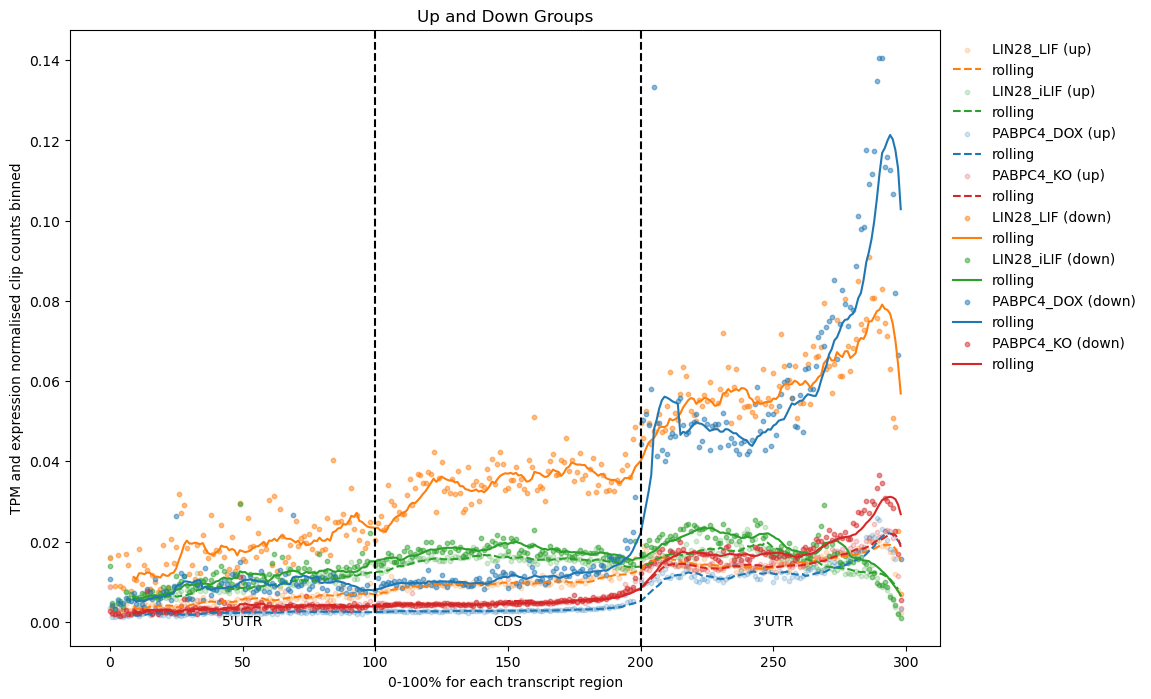

In [52]:
# Define the offsets
offset_dict = {'Five': 0, 'CDS': 100, 'Three': 200}
separator_lines = [100, 200]
include_clip_info = ['LIN28_iLIF', 'LIN28_LIF', 'PABPC4_DOX', 'PABPC4_KO']


# Preprocess the dataframes into a single large dataframe suitable for seaborn
dataframes = []
for key, value in result_dict.items():
    df = pd.DataFrame(value[0])  # Assuming 'value' is a dataframe
    df = df.reset_index().rename(columns={'index': 'x'})  # Reset the index and rename the new column to 'x'
    key_parts = key.split('_')
    section = key_parts[0]  # Extract the section ('5_prime', 'CDS', '3_prime') from the key
    df['x'] += offset_dict[section]  # Offset the x-coordinates
    df['bed_clip'] = key  # Add column indicating the combination
    df['clip_info'] = '_'.join(key_parts[-2:])  # Extract the clip data info from the key
    df['group'] = key_parts[-5]
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)
    dataframes.append(df)

# Concatenate all dataframes into one
plot_data_df = pd.concat(dataframes)

plot_data_df.sort_values('x', inplace=True)

# Create a color palette for the unique clip_info labels
# Define your colors (as many as you need)
#colors = ['orange', 'red', 'green', 'purple', 'yellow', 'blue']
colors = ["#ff7f0e", "#1f77b4",  "#2ca02c", "#d62728", "#9467bd", "#8c564b"]

# Create a dictionary with unique 'clip_info' values and corresponding colors
palette = dict(zip(plot_data_df['clip_info'].unique(), colors))
# Create a single figure (not two subplots)
fig, ax = plt.subplots(figsize=(12, 8))

# Line styles for 'up' and 'down' groups
line_styles = {'up': '--', 'down': '-'}

# Alpha levels for 'up' and 'down' groups
alpha_levels = {'up': 0.2, 'down': 0.5}

# Darker color palette for 'down' group
darker_colors = ["#cc5500", "#174a7c",  "#1c7022", "#9b1b14", "#673697", "#663300"]
dark_palette = dict(zip(plot_data_df[plot_data_df['group'] == 'down']['clip_info'].unique(), darker_colors))
print(palette)
print(dark_palette)
# Process each group separately, but plot in the same axes
for group, linestyle in line_styles.items():
    group_df = plot_data_df[plot_data_df['group'] == group]
    group_df = group_df[group_df['clip_info'].isin(include_clip_info)]
    
    for clip_info, clip_group_df in group_df.groupby('clip_info'):
        clip_group_df = clip_group_df.sort_values('x')  # Ensure data is sorted by 'x'
        clip_group_df['rolling'] = clip_group_df[0].rolling(window=10).mean()
        
        if group == 'down':
            clip_group_df.plot.scatter(x='x', y=0, ax=ax, label=f'{clip_info} ({group})', color=palette[clip_info], s=10, alpha=alpha_levels[group])
            clip_group_df.plot(x='x', y='rolling', ax=ax, color=palette[clip_info], linestyle=linestyle)
        else:
            clip_group_df.plot.scatter(x='x', y=0, ax=ax, label=f'{clip_info} ({group})', color=palette[clip_info], s=10, alpha=alpha_levels[group])
            clip_group_df.plot(x='x', y='rolling', ax=ax, color=palette[clip_info], linestyle=linestyle)
        
for line in separator_lines:
    ax.axvline(x=line, color='k', linestyle='--')  # Add vertical line

ax.set_title('Up and Down Groups')
ax.set_ylabel('TPM and expression normalised clip counts binned')

# Add text inside the plot at custom location
ax.text(50, 0, "5'UTR", fontsize=10, ha='center', va='center')
ax.text(150, 0, "CDS", fontsize=10, ha='center', va='center')
ax.text(250, 0, "3'UTR", fontsize=10, ha='center', va='center')

# Move the legend outside of the plot
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False)

# Adjust the subplot parameters so there is space for the legend.
plt.subplots_adjust(right=0.85)

# set y limit if needed
#ax.set_ylim(0, 0.175)

ax.set_xlabel('0-100% for each transcript region')

plt.savefig('clip_data_metaprofile_full_length_espression_and_library_normalised_lin_and_pabp_fixed_axis.svg', dpi=600, bbox_inches='tight')

plt.show()

{'LIN28_LIF': '#1f77b4', 'PABPC4_DOX': '#ff7f0e', 'LIN28_iLIF': '#2ca02c', 'PABPC4_KO': '#d62728'}


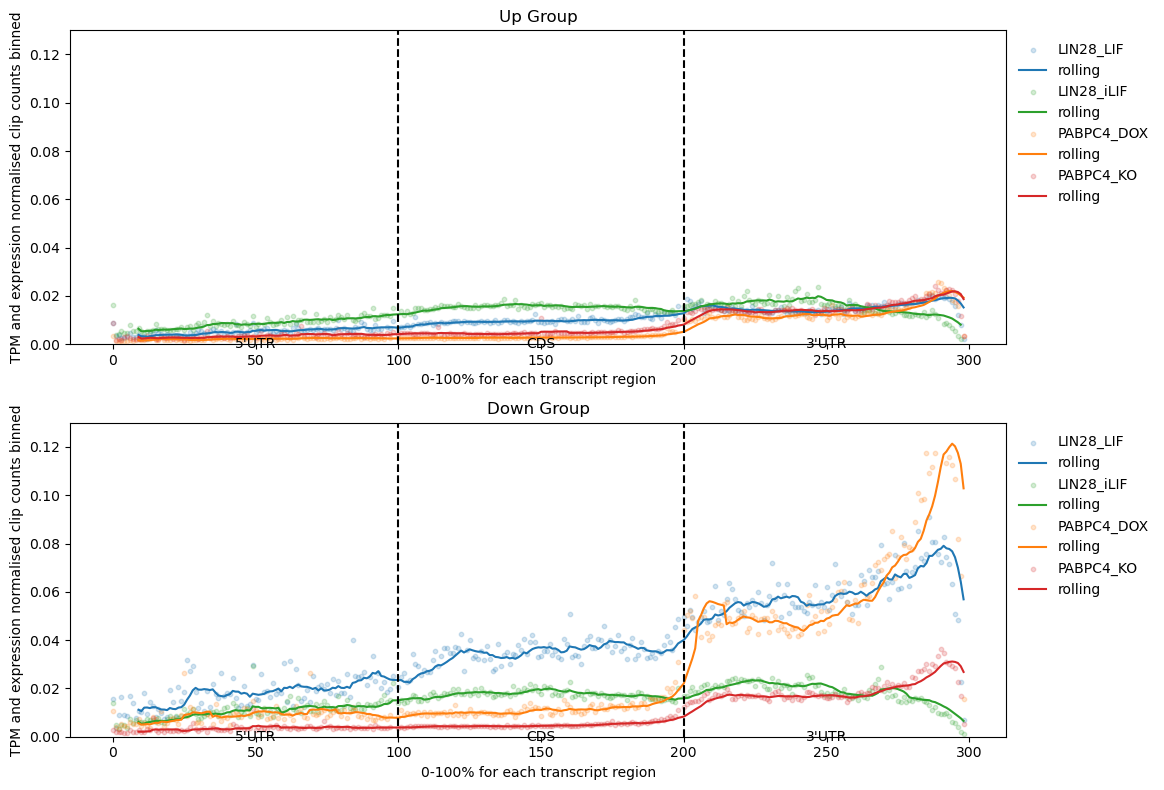

In [58]:
# Define the offsets
offset_dict = {'Five': 0, 'CDS': 100, 'Three': 200}
separator_lines = [100, 200]
include_clip_info = ['LIN28_iLIF', 'LIN28_LIF', 'PABPC4_DOX', 'PABPC4_KO']


# Preprocess the dataframes into a single large dataframe suitable for seaborn
dataframes = []
for key, value in result_dict.items():
    df = pd.DataFrame(value[0])  # Assuming 'value' is a dataframe
    df = df.reset_index().rename(columns={'index': 'x'})  # Reset the index and rename the new column to 'x'
    key_parts = key.split('_')
    section = key_parts[0]  # Extract the section ('5_prime', 'CDS', '3_prime') from the key
    df['x'] += offset_dict[section]  # Offset the x-coordinates
    df['bed_clip'] = key  # Add column indicating the combination
    df['clip_info'] = '_'.join(key_parts[-2:])  # Extract the clip data info from the key
    df['group'] = key_parts[-5]
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)
    dataframes.append(df)

# Concatenate all dataframes into one
plot_data_df = pd.concat(dataframes)

plot_data_df.sort_values('x', inplace=True)

# Create a figure with two subplots (up and down)
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

# Create a color palette for the unique clip_info labels
# Define your colors (as many as you need)
#colors = ['orange', 'red', 'green', 'purple', 'yellow', 'blue']
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b"]

# Create a dictionary with unique 'clip_info' values and corresponding colors
palette = dict(zip(plot_data_df['clip_info'].unique(), colors))
print(palette)

# Calculate rolling averages and plot for 'up' group
up_df = plot_data_df[plot_data_df['group'] == 'up']
up_df = up_df[up_df['clip_info'].isin(include_clip_info)]

for clip_info, group_df in up_df.groupby('clip_info'):
    group_df = group_df.sort_values('x')  # Ensure data is sorted by 'x'
    group_df['rolling'] = group_df[0].rolling(window=10).mean()
    group_df.plot.scatter(x='x', y=0, ax=ax[0], label=clip_info, color=palette[clip_info], s=10, alpha=0.2)
    group_df.plot(x='x', y='rolling', ax=ax[0], color=palette[clip_info])
for line in separator_lines:
    ax[0].axvline(x=line, color='k', linestyle='--')  # Add vertical line
ax[0].set_title('Up Group')
ax[0].set_ylabel('TPM and expression normalised clip counts binned')

# Calculate rolling averages and plot for 'down' group
down_df = plot_data_df[plot_data_df['group'] == 'down']
down_df = down_df[down_df['clip_info'].isin(include_clip_info)]

for clip_info, group_df in down_df.groupby('clip_info'):
    group_df = group_df.sort_values('x')  # Ensure data is sorted by 'x'
    group_df['rolling'] = group_df[0].rolling(window=10).mean()
    group_df.plot.scatter(x='x', y=0, ax=ax[1], label=clip_info, color=palette[clip_info], s=10, alpha=0.2)
    group_df.plot(x='x', y='rolling', ax=ax[1], color=palette[clip_info])
for line in separator_lines:
    ax[1].axvline(x=line, color='k', linestyle='--')  # Add vertical line
ax[1].set_title('Down Group')
ax[1].set_ylabel('TPM and expression normalised clip counts binned')

# Show the plot
plt.tight_layout()

# Add text inside the plot at custom location
ax[0].text(50, 0, "5'UTR", fontsize=10, ha='center', va='center')
ax[0].text(150, 0, "CDS", fontsize=10, ha='center', va='center')
ax[0].text(250, 0, "3'UTR", fontsize=10, ha='center', va='center')
ax[1].text(50, 0, "5'UTR", fontsize=10, ha='center', va='center' )
ax[1].text(150, 0, "CDS", fontsize=10, ha='center', va='center')
ax[1].text(250, 0, "3'UTR", fontsize=10, ha='center', va='center')

# Move the legend outside of the plot
ax[0].legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False)
ax[1].legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False)

# Adjust the subplot parameters so there is space for the legend.
plt.subplots_adjust(right=0.85)

# set y limit
ax[0].set_ylim(0, 0.13)
ax[1].set_ylim(0, 0.13)

ax[0].set_xlabel('0-100% for each transcript region')
ax[1].set_xlabel('0-100% for each transcript region')

plt.savefig('clip_data_metaprofile_full_length_and_library_normalised_lin_pybp_separate_set_scale.svg', dpi=600, bbox_inches='tight')

plt.show()